<a href="https://colab.research.google.com/github/sayevvv/PBL_MoneyClassification/blob/main/PBL_XGBOOSTV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#XGBOOST V2
Melatih Model XGBoost
pada Fitur Gabungan (Warna + Tekstur + Bentuk)

Langkah-langkah:
1. Install XGBoost, import library, dan mount Drive.
2. Load fitur V2 (X_v2) dan label (y_v2).
3. Kumpulkan semua path gambar asli untuk visualisasi.
4. Encode label dan bagi data (X, y, dan path) menjadi train/test set.
5. Lakukan Hyperparameter Tuning (GridSearchCV) untuk XGBoost.
6. Evaluasi model (Classification Report & Confusion Matrix).
7. Visualisasikan hasil prediksi pada gambar tes.
8. Simpan model V2 yang sudah terlatih.

In [1]:
# -----------------------------------------------------
# LANGKAH 1: INSTALASI, IMPORT LIBRARY, DAN MOUNT DRIVE
# -----------------------------------------------------

# Install xgboost jika belum ada di Colab (biasanya sudah ada, tapi untuk memastikan)
!pip install xgboost

import os
import cv2
import joblib
import numpy as np
from tqdm import tqdm
from google.colab import drive
import xgboost as xgb  # Import XGBoost

# Import dari Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder  # Kita tetap butuh LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# -----------------------------------------------------
# LANGKAH 2: KONFIGURASI DAN LOAD DATA FITUR V2
# -----------------------------------------------------

# Path tempat Anda menyimpan file .joblib V2
BASE_DIR = '/content/drive/MyDrive/tugas_akhir_semester5/raw_data'
LABELS = ['1000', '2000', '5000', '10000', '20000', '50000', '100000']
VALID_EXTENSIONS = ('.jpg', '.jpeg', '.png')

PATH_X = os.path.join(BASE_DIR, 'features_X_v2.joblib')
PATH_Y = os.path.join(BASE_DIR, 'labels_y_v2.joblib')

print("Memuat data fitur V2 yang telah diproses...")

# Cek apakah file ada
if not os.path.exists(PATH_X) or not os.path.exists(PATH_Y):
    print(f"Error: File 'features_X_v2.joblib' atau 'labels_y_v2.joblib' tidak ditemukan.")
    print("Pastikan Anda sudah menjalankan skrip 'preprocess_dataset_v2.py' terlebih dahulu.")
else:
    X = joblib.load(PATH_X)
    y = joblib.load(PATH_Y)

    print(f"Data V2 berhasil dimuat.")
    print(f"Bentuk (shape) X_v2: {X.shape}")
    print(f"Bentuk (shape) y_v2: {y.shape}")

Memuat data fitur V2 yang telah diproses...
Data V2 berhasil dimuat.
Bentuk (shape) X_v2: (1651, 469)
Bentuk (shape) y_v2: (1651,)


In [4]:
# -----------------------------------------------------
# LANGKAH 3: KUMPULKAN PATH GAMBAR
# -----------------------------------------------------
# (Langkah ini identik dengan skrip SVM V2,
# diperlukan untuk visualisasi)

print("\nMengumpulkan path gambar asli untuk visualisasi...")
filepaths = []

for label in LABELS:
    label_path = os.path.join(BASE_DIR, label)

    if not os.path.isdir(label_path):
        continue

    image_files = os.listdir(label_path)

    for image_file in tqdm(image_files, desc=f"Mengindeks {label}"):
        if image_file.lower().endswith(VALID_EXTENSIONS):
            full_path = os.path.join(label_path, image_file)
            filepaths.append(full_path)

print("Path gambar berhasil dikumpulkan.")

# Pengecekan Kritis
if len(filepaths) != X.shape[0]:
    print(f"PERINGATAN KRITIS: Jumlah fitur ({X.shape[0]}) tidak cocok "
          f"dengan jumlah path gambar ({len(filepaths)}).")
    print("Visualisasi mungkin tidak akan akurat.")
else:
    print("Jumlah fitur dan path gambar cocok. Melanjutkan...")


Mengumpulkan path gambar asli untuk visualisasi...


Mengindeks 100000: 100%|██████████| 240/240 [00:00<00:00, 381734.15it/s]

Path gambar berhasil dikumpulkan.
Jumlah fitur dan path gambar cocok. Melanjutkan...


In [5]:
    # -----------------------------------------------------
    # LANGKAH 4: ENCODE LABEL DAN BAGI DATA
    # -----------------------------------------------------

    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    class_names = le.classes_
    print(f"\nLabel berhasil di-encode. Kelas: {class_names}")

    # Simpan LabelEncoder ini! Penting untuk Flask
    # (Tidak masalah menimpanya, isinya sama dengan SVM v2)
    le_path = os.path.join(BASE_DIR, 'label_encoder_v2.joblib')
    joblib.dump(le, le_path)
    print(f"LabelEncoder V2 disimpan di: {le_path}")

    # Bagi data X, y, dan filepaths secara bersamaan
    X_train, X_test, y_train, y_test, paths_train, paths_test = train_test_split(
        X, y_encoded, filepaths,
        test_size=0.2,
        random_state=42,
        stratify=y_encoded
    )

    print(f"\nData dibagi:")
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"Jumlah path tes: {len(paths_test)}")


Label berhasil di-encode. Kelas: ['1000' '10000' '100000' '2000' '20000' '5000' '50000']
LabelEncoder V2 disimpan di: /content/drive/MyDrive/tugas_akhir_semester5/raw_data/label_encoder_v2.joblib

Data dibagi:
X_train shape: (1320, 469)
X_test shape: (331, 469)
Jumlah path tes: 331


In [6]:
    # -----------------------------------------------------
    # LANGKAH 6: HYPERPARAMETER TUNING (GRIDSEARCHCV)
    # -----------------------------------------------------

    print("\nMemulai Hyperparameter Tuning dengan GridSearchCV untuk XGBoost (V2)...")

    # Tentukan parameter yang ingin diuji untuk XGBoost
    # Ini adalah set parameter yang lebih sederhana agar tuning lebih cepat
    param_grid = {
        'n_estimators': [100, 200],      # Jumlah pohon
        'max_depth': [3, 5],             # Kedalaman maksimum pohon
        'learning_rate': [0.1, 0.05]     # Seberapa cepat model belajar
    }

    # Inisialisasi model XGBoost
    xgb_model = xgb.XGBClassifier(
        objective='multi:softmax',  # Untuk klasifikasi multi-kelas
        num_class=len(class_names), # Jumlah kelas Anda
        use_label_encoder=False,
        eval_metric='mlogloss'
    )

    # Siapkan GridSearchCV
    grid = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        refit=True,     # Otomatis melatih model terbaik pada semua data latih
        verbose=2,
        cv=3,           # 3-fold cross-validation
        n_jobs=-1       # Gunakan semua core CPU
    )

    # Latih GridSearchCV pada data (TIDAK di-scale)
    grid.fit(X_train, y_train)


Memulai Hyperparameter Tuning dengan GridSearchCV untuk XGBoost (V2)...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:27:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constrain...
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_class=7, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.05], 'max_depth': [3, 5],
                         'n_estimators': [100, 200]},
             verbose=2)


Tuning XGBoost V2 selesai!
Parameter terbaik yang ditemukan: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}

--- Laporan Klasifikasi XGBoost (V2) ---
              precision    recall  f1-score   support

        1000       1.00      0.98      0.99        48
       10000       1.00      1.00      1.00        48
      100000       0.98      0.96      0.97        48
        2000       0.98      1.00      0.99        48
       20000       1.00      1.00      1.00        48
        5000       0.98      1.00      0.99        45
       50000       1.00      1.00      1.00        46

    accuracy                           0.99       331
   macro avg       0.99      0.99      0.99       331
weighted avg       0.99      0.99      0.99       331

Akurasi Keseluruhan (V2): 99.09%

--- Confusion Matrix (V2) ---


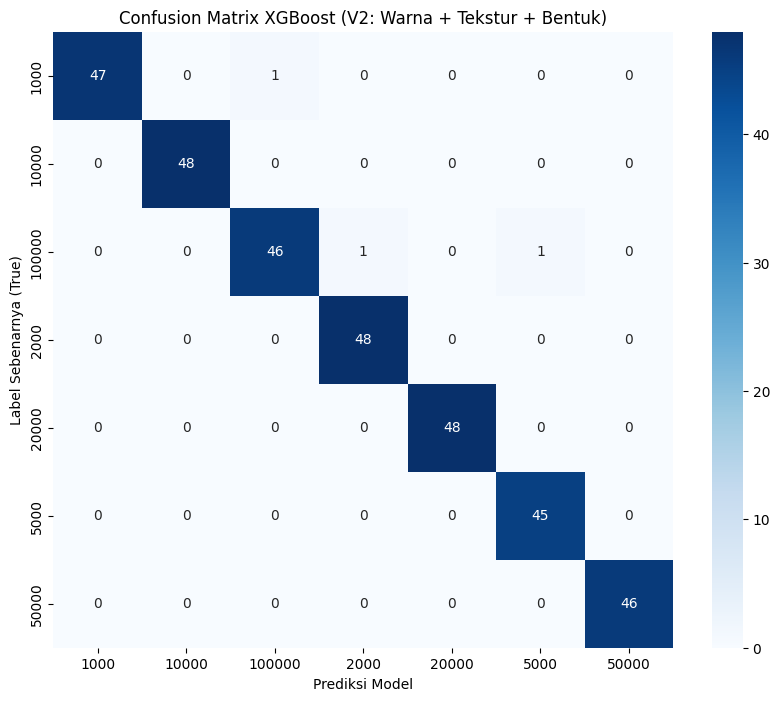

In [7]:
    # -----------------------------------------------------
    # LANGKAH 7: EVALUASI MODEL V2
    # -----------------------------------------------------

    print("\nTuning XGBoost V2 selesai!")
    print(f"Parameter terbaik yang ditemukan: {grid.best_params_}")

    best_xgb = grid.best_estimator_
    y_pred = best_xgb.predict(X_test) # Prediksi pada X_test (TIDAK di-scale)

    print("\n--- Laporan Klasifikasi XGBoost (V2) ---")
    print(classification_report(y_test, y_pred, target_names=class_names))

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Akurasi Keseluruhan (V2): {accuracy * 100:.2f}%")

    print("\n--- Confusion Matrix (V2) ---")
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Prediksi Model')
    plt.ylabel('Label Sebenarnya (True)')
    plt.title('Confusion Matrix XGBoost (V2: Warna + Tekstur + Bentuk)')
    plt.show()


Memulai visualisasi hasil prediksi pada data tes...
Total tebakan benar: 328
Total tebakan salah: 3


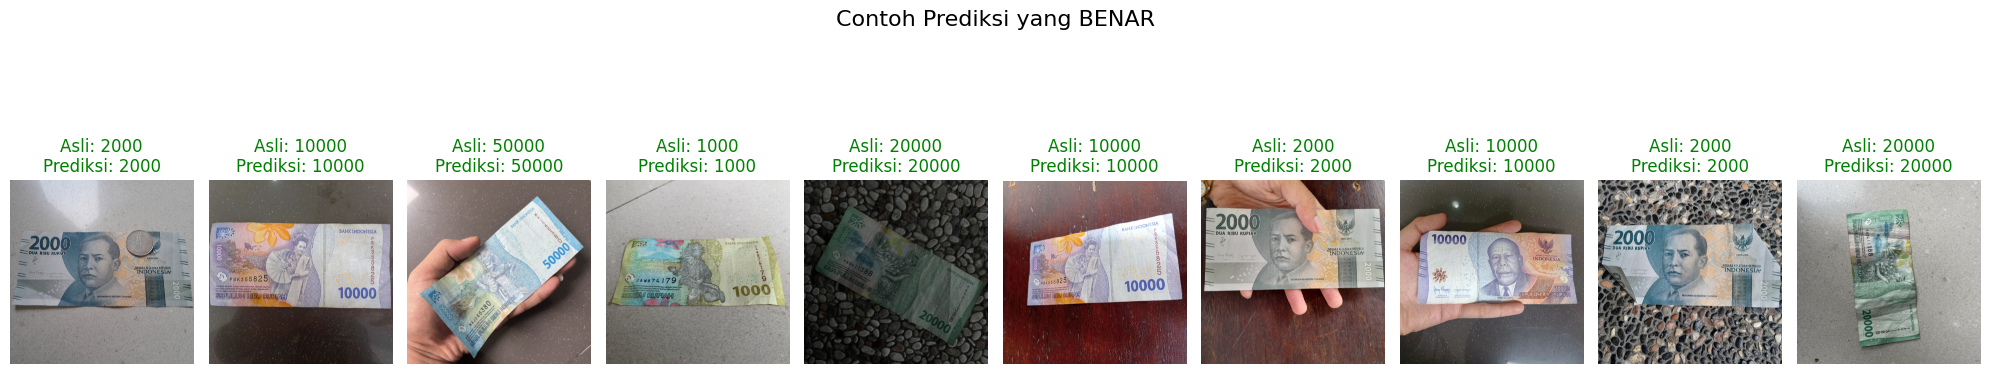

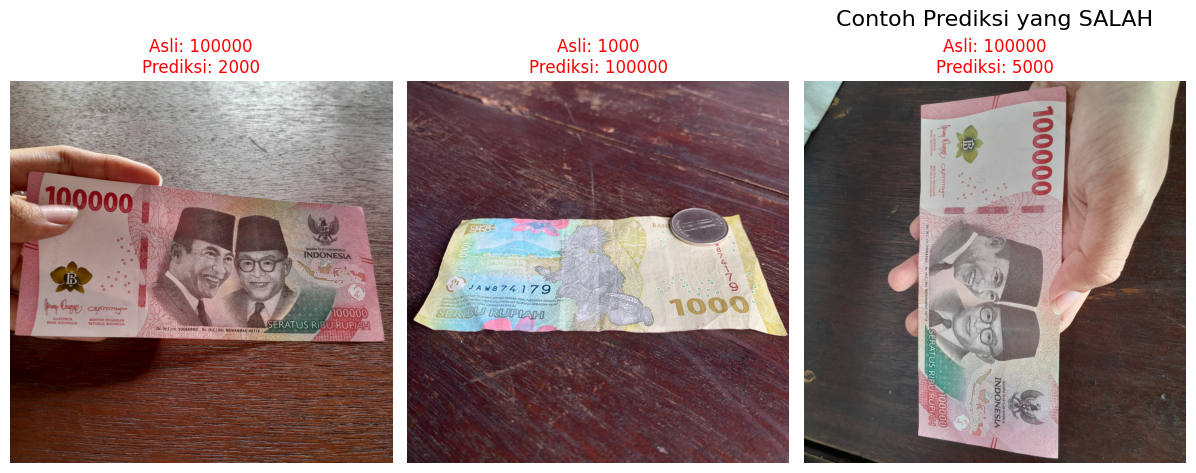

In [9]:
    # -----------------------------------------------------
    # LANGKAH 8: VISUALISASI HASIL TES
    # -----------------------------------------------------

    print("\nMemulai visualisasi hasil prediksi pada data tes...")

    # (Logika ini identik dengan skrip SVM, jadi bisa langsung dipakai)
    correct_indices = np.where(y_pred == y_test)[0]
    incorrect_indices = np.where(y_pred != y_test)[0]

    print(f"Total tebakan benar: {len(correct_indices)}")
    print(f"Total tebakan salah: {len(incorrect_indices)}")

    # Fungsi untuk menampilkan gambar
    def show_prediction_images(indices, title, n_images=5):
        if len(indices) == 0:
            print(f"Tidak ada gambar untuk ditampilkan (tidak ada {title.lower()})")
            return

        # Ambil N gambar secara acak dari indeks
        sample_indices = np.random.choice(indices, min(n_images, len(indices)), replace=False)

        plt.figure(figsize=(20, 5))
        plt.suptitle(f"Contoh Prediksi yang {title}", fontsize=16)

        for i, idx in enumerate(sample_indices):
            # Baca gambar dari path
            img_path = paths_test[idx]
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Konversi BGR ke RGB untuk plt

            # Dapatkan label
            true_label = class_names[y_test[idx]]
            pred_label = class_names[y_pred[idx]]

            # Tentukan warna judul
            color = "green" if title == "BENAR" else "red"

            plt.subplot(1, n_images, i + 1)
            plt.imshow(img)
            plt.title(f"Asli: {true_label}\nPrediksi: {pred_label}", color=color)
            plt.axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    # Tampilkan 5 contoh yang BENAR
    show_prediction_images(correct_indices, "BENAR", n_images=10)

    # Tampilkan 5 contoh yang SALAH (jika ada)
    show_prediction_images(incorrect_indices, "SALAH", n_images=5)